In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

%run './Chicago_Car_Crashes.py'

## DATA COLLECTION

In [4]:
df = pd.read_csv('./data/Chicago_Traffic_Crashes_2020.csv.gz', low_memory=False)

In [3]:
target_column = joblib.load('../pkl/target_column.pkl')
ohe_target = OneHotEncoder(handle_unknown='ignore', sparse=False)
df_target  = pd.DataFrame(ohe_target.fit_transform(df[target_column].values.reshape(-1,1)),
                         columns=ohe_target.categories_)
df_target.columns = df_target.columns.get_level_values(0).str.replace(' ', '_')

In [4]:
X, y = df.drop(target_column, axis=1), df_target['UNABLE_TO_DETERMINE']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=264, stratify=y)

In [5]:
speed_column  = joblib.load('../pkl/speed_column.pkl')
speed_transformer = Pipeline([
    ('impute_speed',  SpeedTransformer()),
    ('ohe_speed', OneHotEncoder(sparse=False)) ])

categoric_columns    = joblib.load('../pkl/categoric_columns.pkl')
categoric_transformer = Pipeline([
    ('Imputer_cat', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='UNKNOWN')),
    ('onehot', OneHotEncoder(sparse=False)) ])

preprocessing = ColumnTransformer(
    transformers = [
        ('speed', speed_transformer, speed_column),
        ('categoric', categoric_transformer, categoric_columns) ])

rfc_pipeline = Pipeline(steps=[
    ('transformer', preprocessing),
    ('classifier', RandomForestClassifier(**joblib.load('../pkl/RF_Grid_Search_best_params')))
])

In [6]:
rfc_pipeline_obj = rfc_pipeline.fit(x_train, y_train)
y_train_pred = rfc_pipeline.predict(x_train)

In [10]:
print(f"{'ROC_AUC SCORE:':15} {roc_auc_score(y_train, y_train_pred)}")
print(f"{'ACCURACY SCORE':15} {accuracy_score(y_train, y_train_pred)}")

ROC_AUC SCORE:  0.736624998382062
ACCURACY SCORE  0.7423301336344814


In [7]:
rfc_pipeline_obj = rfc_pipeline.fit(x_test, y_test)
y_test_pred = rfc_pipeline.predict(x_test)

In [11]:
print(f"{'ROC_AUC SCORE:':15} {roc_auc_score(y_test, y_test_pred)}")
print(f"{'ACCURACY SCORE':15} {accuracy_score(y_test, y_test_pred)}")

ROC_AUC SCORE:  0.7729098268147521
ACCURACY SCORE  0.7803500846979108


In [24]:
features_importance = rfc_pipeline.named_steps.classifier.feature_importances_

speed_encoed_columns = rfc_pipeline.named_steps.transformer.named_transformers_.speed.named_steps.ohe_speed\
.get_feature_names(input_features=speed_column)

features_encoded_columns = rfc_pipeline.named_steps.transformer.named_transformers_.categoric.named_steps.onehot\
.get_feature_names(input_features=categoric_columns)

features_importance_cols = np.concatenate([speed_encoed_columns,features_encoded_columns])

In [25]:
Features_importance_df = pd.DataFrame({'Features': features_importance_cols,
                          'Ranking': features_importance}).sort_values(by='Ranking',ascending=False)

Features_importance_df['Ranking'] = Features_importance_df['Ranking'].apply(lambda x: x*100)

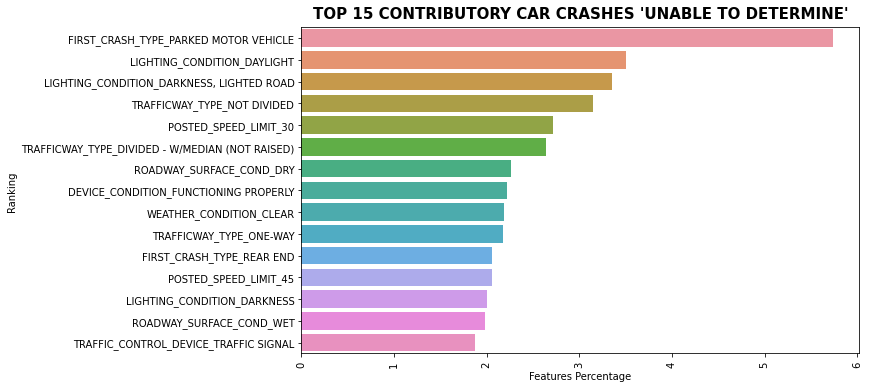

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
g = sns.barplot(x='Ranking', y='Features', data=Features_importance_df.head(15))
plt.xticks(rotation=90)
ax.set_title("TOP 15 CONTRIBUTORY CAR CRASHES 'UNABLE TO DETERMINE'", fontsize=15, weight='bold', ha='center', va='bottom')

ax.set_xlabel('Features Percentage')
ax.set_ylabel('Ranking')
plt.show()